In [22]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import networkx as nx

from dataclasses import dataclass
from typing import Iterable

In [60]:
# Need a cruft check on these

import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Sequential as Seq, Linear, ReLU

ModuleNotFoundError: No module named 'torch_sparse'

In [48]:
import xbatcher as xb

In [25]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [26]:
target = ['U', 'V']

In [27]:
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

In [28]:
%run ./surface_currents_prep.ipynb

In [ ]:
prepare_data(sc5, 200, 1000, 1000, 200)

In [29]:
ds_training = load_training_data(sc5)
ds_training = just_the_data(ds_training)
ds_training = select_from(ds_training)
ds_training

<xarray.Dataset>
Dimensions:  (nlat: 550, nlon: 350)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(550, 350), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(100, 350), meta=np.ndarray>

In [30]:
def random_array(nan_mask):
    return np.random.rand(nan_mask.shape) * nan_mask

In [31]:
def map2d(array, func):
    return [[func(y, i, j) for j, y in enumerate(x)] for i, x in enumerate(array)]

In [32]:
def map2d_test():
    sample = np.random.choice(a=[False, True], size=(20, 20))
    pred1 = lambda x, *_: not x
    not_sample = map2d(sample, pred1)
    np.testing.assert_array_equal(sample, map2d(not_sample, pred1))
    pass

In [33]:
map2d_test()

In [34]:
def distance_from(array, point_i, point_j):
    dist = lambda _, i, j: np.sqrt(float(point_i - i)**2 + float(point_j - j)**2)
    return map2d(array, dist)

def distance_mask(array, point_i, point_j):
    size = array.shape[0]
    dist = distance_from(array, point_i, point_j)
    return map2d(dist, lambda x, *_: (x < size*0.4))

def corners():
    size = 12
    z = np.zeros([size, size])

    bl = np.array(distance_mask(z, 0,    0), dtype=bool)
    br = np.array(distance_mask(z, size, 0), dtype=bool)
    tl = np.array(distance_mask(z, 0, size), dtype=bool)
    tr = np.array(distance_mask(z, size, size), dtype=bool)
    
    corners_mask = bl + br + tl + tr
    
    a = np.where(corners_mask, np.random.rand(1), np.NAN)
    return(a)

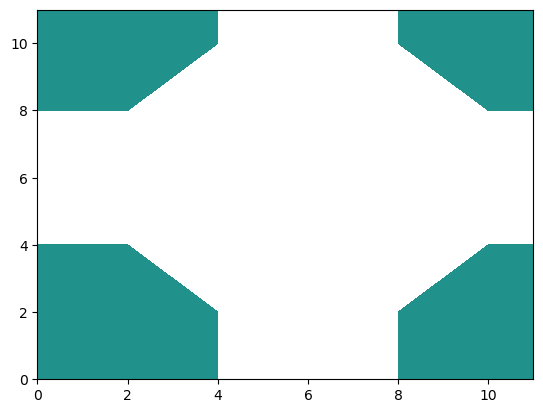

In [35]:
plt.contourf(corners())

In [36]:
def diag_mask(array):
    size = array.shape[0]
    return map2d(array, lambda _, i, j: (np.abs(i - j) > np.ceil(size/8.)))

def diag():
    size = 7
    z = np.zeros([size, size])
    a = np.where(diag_mask(z), np.random.rand(1), np.NAN)
    return(a)

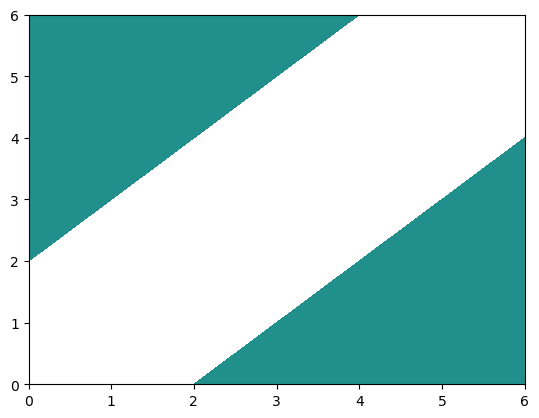

In [37]:
plt.contourf(diag())

In [38]:
def point_degree(array, i, j):
    return np.sum(np.isnan([array([i,j+1]),
                            array([i,j-1]),
                            array([i+1,j]),
                            array([i-1,j])]))

# Uses a "+"-shaped stencil for graph edges
def point_to_graph(array, i, j, imax, jmax):
    edges = []

    if not (j == jmax):
        if not np.isnan(array[i,j+1]):
            edges.append([(i,j), (i,j+1), 1.])

    if not (i == imax):
        if not np.isnan(array[i+1,j]):
            edges.append([(i,j), (i+1,j), 1.])

    return edges

def array_to_graph(array):
    graph = nx.Graph()
    imax = array.shape[0]-1
    jmax = array.shape[1]-1
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not np.isnan(array[i,j]):
                graph.add_node((i,j))
                edges = point_to_graph(array, i, j, imax, jmax)
                graph.add_weighted_edges_from(edges)
            
    return graph

def mask_to_graph(mask):
    array = np.zeros(mask.shape)
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not mask[i, j]:
                array[i, j] = np.nan
    return array_to_graph(array)

def array_to_subgraphs(array):
    g = array_to_graph(array)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

def mask_to_subgraphs(mask):
    g = mask_to_graph(mask)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

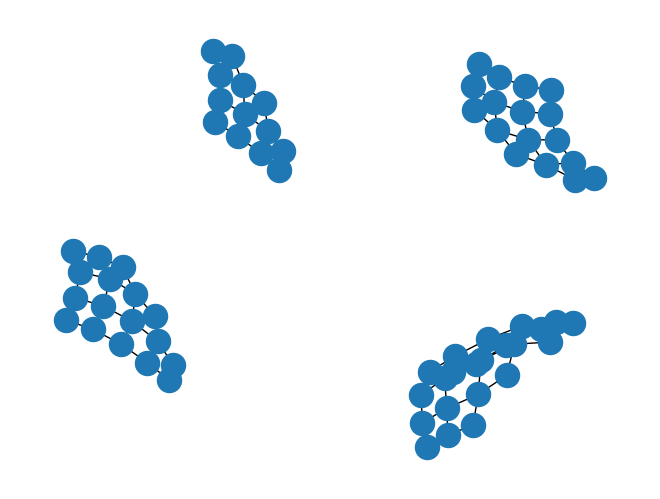

In [39]:
c = corners()
gc = array_to_graph(c)
nx.draw(gc)

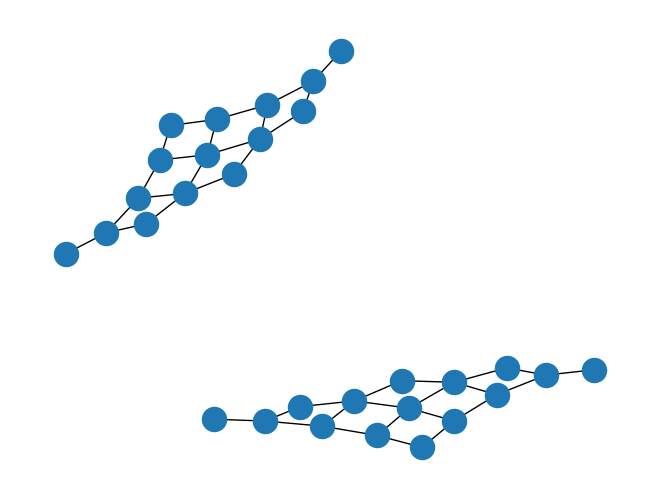

In [40]:
d = diag()
gd = array_to_graph(d)
nx.draw(gd)

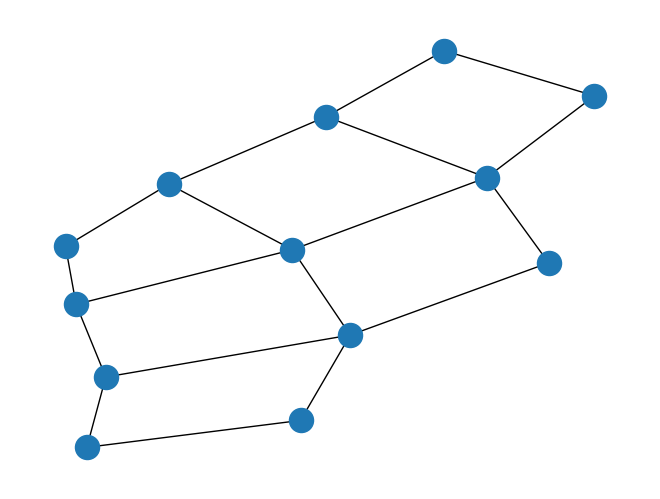

In [41]:
subgc = array_to_subgraphs(c)
subgd = array_to_subgraphs(d)
nx.draw(subgc[3])

In [73]:
def batch_to_graph(batch, sc):
    mask = batch['mask'][0].to_numpy()
    conv_f   = {x:batch[x][0].to_numpy() for x in sc.conv_var}
    features = {x:batch[x][0].to_numpy() for x in sc.input_var}
    targets  = {x:batch[x][0].to_numpy() for x in sc.target}
    conv_f_graph   = nx.Graph()
    features_graph = nx.Graph()
    targets_graph  = nx.Graph()
    
    
    def point_to_graph(mask, i, j, imax, jmax):
        edges = []

        if not (j == jmax):
            if mask[i, j+1]:
                edges.append([(i,j), (i,j+1), 1.])

        if not (i == imax):
            if mask[i+1,j]:
                edges.append([(i,j), (i+1,j), 1.])

        return edges
    
    imax = mask.shape[0]-1
    jmax = mask.shape[1]-1
    for i in range(0, mask.shape[0]):
        for j in range(0,mask.shape[1]):
            if mask[i, j]:
                conv_f_ij   = {x:conv_f  [x][i,j] for x in sc.conv_var}
                features_ij = {x:features[x][i,j] for x in sc.input_var}
                targets_ij  = {x:targets [x][i,j] for x in sc.target}
                conv_f_graph.add_node((i,j),   **conv_f_ij)
                features_graph.add_node((i,j), **features_ij)
                targets_graph.add_node((i,j),  **targets_ij)
                conv_f_graph.add_weighted_edges_from(point_to_graph(mask, i, j, imax, jmax),)
                features_graph.add_weighted_edges_from(point_to_graph(mask, i, j, imax, jmax),)
                targets_graph.add_weighted_edges_from(point_to_graph(mask, i, j, imax, jmax),)

    return conv_f_graph, features_graph, targets_graph
    
def batch_to_subgraphs(batch, sc):
    c, f, t = batch_to_graph(batch, sc)
    csub = [c.subgraph(sub) for sub in nx.connected_components(c)]
    fsub = [f.subgraph(sub) for sub in nx.connected_components(f)]
    tsub = [t.subgraph(sub) for sub in nx.connected_components(t)]
    return csub, fsub, tsub
    

In [74]:
# bgen = xb.BatchGenerator(
#     ds_training,
#     {'nlon':6, 'nlat':6},
#     {'nlon':2, 'nlat':2}
# )

In [75]:
# for batch in bgen:
#     a = batch
#     break
# a

In [76]:
# TEMP: formalize this

nlats = 5
nlons = 5
halo_size=1

In [77]:
latlen = len(ds_training['nlat'])
lonlen = len(ds_training['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch = (
    ds_training
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

In [78]:
rnds = list(range(len(batch['input_batch'])))
np.random.shuffle(rnds)

In [79]:
batch = batch[{'input_batch':(rnds)}]
batch

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 3100 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (input_batch: 20930, nlat: 5, nlon: 5)
Dimensions without coordinates: input_batch, nlat, nlon
Data variables:
    SSH      (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    SST      (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    TAUX     (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    TAUY     (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    U        (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    V        (input_batch, nlat, nlon) float32 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    X        (input_batch, nlat, nlon) float64 dask.array<chunksize=(20930, 5, 5), meta=np.ndarray>
    mask     (input_batch, nlat, nlon) object dask.array<chunksize=(1, 5, 5), meta=np.ndarray>

In [80]:
# use with rolling
def batch_generator(batch_set, batch_size):
    n = 0
    while n < len(batch_set['input_batch']) - batch_size:
        yield batch_set.isel({'input_batch':range(n,(n+batch_size))})
        n += batch_size
        
# # use with xbatcher
# def batch_generator(bgen, batch_size):
#     b = (batch for batch in bgen)
#     n = 0
#     while n < 400:
#         batch_stack = [ next(b) for i in range(batch_size) ]
#         yield xr.concat(batch_stack, 'sample')
#         n += 1

In [81]:
bgen = batch_generator(batch, 4096)
# bgen = batch_generator(bgen, 32)

In [82]:
def bgen_to_graph(bgen, sc):
    for batch in bgen:
        csub, fsub, tsub = batch_to_subgraphs(batch, sc)
        for i in range(len(fsub)):
            yield csub[i], fsub[i], tsub[i]
            
# def count_bgen_subgraphs(bgen, sc)
#     ct = 0
#     for batch in bgen:
#         f, _ = batch_to_subgraphs(batch, sc)
#         ct += len(f)
#     return ct

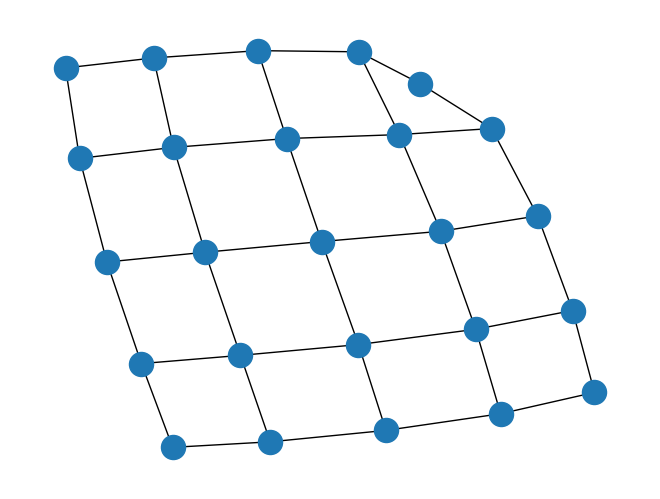

In [83]:
for cg, fg, tg in bgen_to_graph(bgen, sc5):
    nx.draw(fg)
    break